# CTC Loss with OCR

References
* https://en.wikipedia.org/wiki/Connectionist_temporal_classification
* https://keras.io/examples/vision/captcha_ocr/#model
* https://distill.pub/2017/ctc/

Resources
* https://jref.com/resources/ms-gothic.53/

In [1]:
# https://jref.com/resources/ms-gothic.53/
#!wget https://jref.com/resources/ms-gothic.53/download
#!unzip msgothic.zip

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont, ImageOps
import tensorflow as tf
from difflib import SequenceMatcher

try:
    # Japanese language support for matplotlib.
    import japanize_matplotlib
except:
    !pip install japanize_matplotlib
    import japanize_matplotlib
    
try:
    DEVICE_NAME = tf.test.gpu_device_name()
    print("Found GPU at: {}".format(DEVICE_NAME))
except:
    DEVICE_NAME = "/device:CPU:0"
    print("ERROR: Not connected to a GPU runtime.")

# OCR Images

In [3]:
# Make train-valid-test splits of images and labels.
N_train = 10000
N_valid = 2000
N_test = 2000

# Image dimensions.
height = 32
width = 512

min_len = 4
max_len = 16

# Japanese characters used to make the data.
katakana = "アイウエオカキクケコサシスセソタチツテトナニヌネノハヒフヘホマミムメモヤユヨラリルレロワヲン"
kanji =    "阿伊宇江於加幾久介己散之須世曽多千川天止奈仁奴祢乃八比不部保末三牟女毛也由與良利流礼呂和乎尓"
katakana_small = "ｱｲｳｴｵｶｷｸｹｺｻｼｽｾｿﾀﾁﾂﾃﾄﾅﾆﾇﾈﾉﾊﾋﾌﾍﾎﾏﾐﾑﾒﾓﾔﾕﾖﾗﾘﾙﾚﾛﾜｦﾝ"
chars = katakana + katakana_small

chars = sorted([c for c in chars])

# Character to index map and reverse map.
char_to_ind = tf.keras.layers.StringLookup(vocabulary = list(chars), mask_token = None)
ind_to_char = tf.keras.layers.StringLookup(vocabulary = char_to_ind.get_vocabulary(), mask_token = None, invert = True)

# MS Gothic font can be downloaded from: 
# https://jref.com/resources/ms-gothic.53/
font = ImageFont.truetype("./msgothic.ttc", 32)

In [4]:
def make_data(N_samples, min_len = 4, max_len = 10, add_noise = False):
    X = []
    y = []
    # Create N_samples samples of features X and labels y.
    for i in range(N_samples):
        # Each image contains randomly generated text 
        # with random length [4, 10].
        N = np.random.randint(min_len, max_len + 1)
        text = np.random.choice(chars, N)
        text = "".join(text)
        # Randomly jitter the position of the text in the image.
        # Only the x-coordinate (i.e. the time coordinate)
        # should be jittered.
        #x_pos = 0 + np.random.randint(0, 122 + (max_len - len(text)) * font.size)
        n_blanks = max_len - len(text)
        x_shift = np.random.randint(0, n_blanks + 1)
        x_pos = 0 + x_shift * font.size
        y_pos = np.round((height - font.size) / 2)
        pos = (x_pos, y_pos)
        image = Image.new("RGB", [width, height], (0, 0, 0))
        d = ImageDraw.Draw(image)
        d.text(pos, text, font = font, fill = (255, 255, 255), anchor = "mm")
        image = ImageOps.grayscale(image)
        image = np.array(image)
        # Add Gaussian noise.
        if add_noise == True:
            gn = np.random.normal(loc = 0, scale = np.log(2), size = image.shape)
            image = image + gn
        X.append(image.astype(np.uint8).reshape((height, width, 1)))
        # Make all texts the same length (i.e. max_len).
        # Also ensure no white space before text.
        # These spaces will be converted to zeros by the encoder.
        text = text.strip()
        pad = (max_len - len(text)) * " "
        y.append(text + pad)
    return np.array(X), np.array(y)

X_train, y_train = make_data(N_train, min_len = min_len, max_len = max_len, add_noise = False)
X_valid, y_valid = make_data(N_valid, min_len = min_len, max_len = max_len)
X_test, y_test = make_data(N_test, min_len = min_len, max_len = max_len)

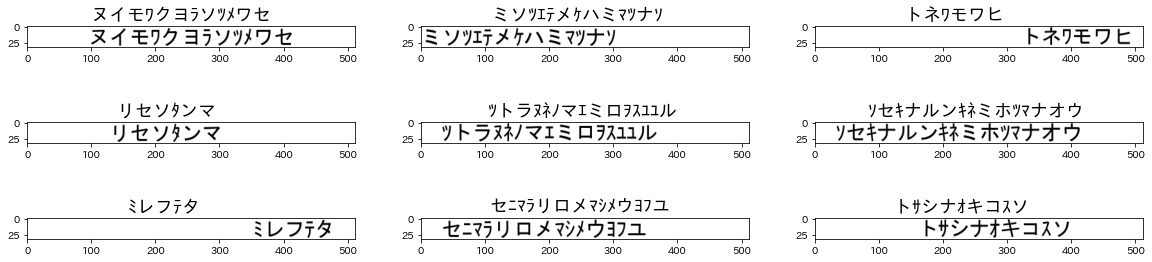

In [5]:
plt.figure(figsize = (20, 5))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(X_train[i][:, :, 0], cmap = "binary")
    plt.title(y_train[i], fontsize = 18)
plt.show()

## TensorFlow Datasets

In [6]:
batch_size = 20

def encode_data(image, label):
    image = tf.keras.layers.Rescaling(1.0 / 255)(image)
    image = tf.transpose(image, perm = [1, 0, 2])
    label = char_to_ind(tf.strings.unicode_split(label,
                                input_encoding = "UTF-8"))
    return {"image": image, "label": label}

with tf.device(DEVICE_NAME):
    # Training data.
    train_ds = tf.data.Dataset.from_tensor_slices((X_train,
                                                   y_train))
    train_ds = train_ds.map(encode_data,
               num_parallel_calls = tf.data.AUTOTUNE)
    train_ds = train_ds.batch(batch_size)
    train_ds = train_ds.prefetch(buffer_size = tf.data.AUTOTUNE)

    # Validation data.
    valid_ds = tf.data.Dataset.from_tensor_slices((X_valid,
                                                   y_valid))
    valid_ds = valid_ds.map(encode_data,
               num_parallel_calls = tf.data.AUTOTUNE)
    valid_ds = valid_ds.batch(batch_size)
    valid_ds = valid_ds.prefetch(buffer_size = tf.data.AUTOTUNE)

    # Testing data.
    test_ds = tf.data.Dataset.from_tensor_slices((X_test,
                                                  y_test))
    test_ds = test_ds.map(encode_data,
              num_parallel_calls = tf.data.AUTOTUNE)
    test_ds = test_ds.batch(batch_size)
    test_ds = test_ds.prefetch(buffer_size = tf.data.AUTOTUNE)

# OCR Model with CTC Loss

In [7]:
class CTCLayer(tf.keras.layers.Layer):
    def __init__(self, name = None):
        super().__init__(name = name)
        self.loss_fn = tf.keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Number of samples in a batch.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype = "int64")
        # Length of the "time steps".
        input_length = tf.cast(tf.shape(y_pred)[1], dtype = "int64")
        input_length = input_length * tf.ones(shape = (batch_len, 
                                             1), dtype = "int64")
        # Length of the label.
        label_length = tf.cast(tf.shape(y_true)[1], dtype = "int64")
        label_length = label_length * tf.ones(shape = (batch_len, 
                                             1), dtype = "int64")
        loss = self.loss_fn(y_true, y_pred, 
                input_length, label_length)
        self.add_loss(loss)
        return y_pred

In [8]:
def make_model(width, height):
    # Inputs
    imgs = tf.keras.layers.Input(shape = (width, height, 1), name = "image", dtype = "float32")
    labels = tf.keras.layers.Input(name = "label", shape = (None,), dtype = "float32")

    # CNN layers.
    x = tf.keras.layers.Conv2D(32, (3, 3), activation = "relu", kernel_initializer = "he_normal", padding = "same", name = "Conv1")(imgs)
    x = tf.keras.layers.MaxPooling2D((2, 2), name = "pool1")(x)

    x = tf.keras.layers.Conv2D(64, (3, 3), activation = "relu", kernel_initializer = "he_normal",padding = "same", name = "Conv2")(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), name = "pool2")(x)

    # Dense layers. After 2 layers of max pooling, the width and
    # height are reduced by a factor of 4. The factor of 64 comes from the
    # number of filters in the previous CNN layer.
    new_shape = ((width // 4), (height // 4) * 64)
    x = tf.keras.layers.Reshape(target_shape = new_shape, name = "reshape")(x)
    x = tf.keras.layers.Dense(1024, activation = "relu", name = "dense1")(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    # RNN layers.
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences = True, dropout = 0.5))(x)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences = True, dropout = 0.5))(x)

    # Dense output layer before the CTC loss. The number of nodes
    # is the number of unique words + 1. The additional node is for
    # a special token which accounts for unknown characters.
    x = tf.keras.layers.Dense(len(char_to_ind.get_vocabulary()) + 1, activation = "softmax", name = "dense2")(x)

    # CTC loss layer.
    output = CTCLayer(name = "ctc_loss")(labels, x)

    model = tf.keras.models.Model(inputs = [imgs, labels], outputs = output, name = "ocr_model")
    opt = tf.keras.optimizers.Adam()
    model.compile(optimizer = opt)
    return model

In [9]:
with tf.device(DEVICE_NAME):
    model = make_model(width, height)
    train_hist = {}

## Model Training

In [10]:
epochs = 10

history = model.fit(train_ds, epochs = epochs, validation_data = valid_ds, verbose = 2)

for k in history.history.keys():
    if k not in train_hist:
        train_hist[k] = []
    train_hist[k] = train_hist[k] + history.history[k]

Epoch 1/10
500/500 - 60s - loss: 52.8022 - val_loss: 48.8854 - 60s/epoch - 121ms/step
Epoch 2/10
500/500 - 34s - loss: 27.5830 - val_loss: 3.1029 - 34s/epoch - 69ms/step
Epoch 3/10
500/500 - 34s - loss: 2.8764 - val_loss: 2.7834 - 34s/epoch - 69ms/step
Epoch 4/10
500/500 - 35s - loss: 2.4097 - val_loss: 2.1890 - 35s/epoch - 70ms/step
Epoch 5/10
500/500 - 40s - loss: 1.5929 - val_loss: 1.1854 - 40s/epoch - 81ms/step
Epoch 6/10
500/500 - 35s - loss: 1.1119 - val_loss: 0.8286 - 35s/epoch - 69ms/step
Epoch 7/10
500/500 - 35s - loss: 0.8586 - val_loss: 0.8341 - 35s/epoch - 71ms/step
Epoch 8/10
500/500 - 35s - loss: 0.6399 - val_loss: 0.5781 - 35s/epoch - 69ms/step
Epoch 9/10
500/500 - 35s - loss: 0.5723 - val_loss: 0.9946 - 35s/epoch - 69ms/step
Epoch 10/10
500/500 - 35s - loss: 0.4997 - val_loss: 0.5071 - 35s/epoch - 69ms/step


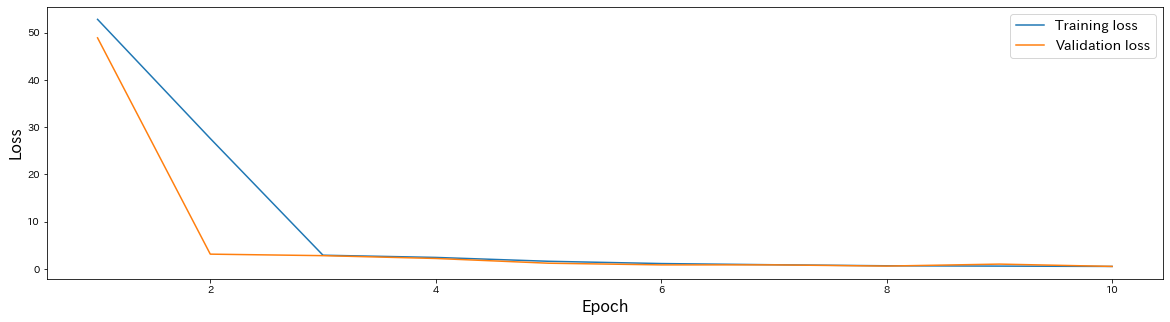

In [11]:
plt.figure(figsize = (20, 5))
plt.plot(range(1, len(train_hist["loss"]) + 1),
         train_hist["loss"])
plt.plot(range(1, len(train_hist["val_loss"]) + 1),
         train_hist["val_loss"])
plt.xlabel("Epoch", fontsize = 16)
plt.ylabel("Loss", fontsize = 16)
plt.legend(["Training loss", "Validation loss"], fontsize = 14)
plt.show()

# Inference & Evaluation

In [12]:
def decode_batch_predictions(pred, max_len = 10):
    # input_len is the product of the batch size and the
    # number of time steps.
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    
    # Decode CTC predictions using greedy search.
    # decoded is a tuple with 2 elements.
    decoded = tf.keras.backend.ctc_decode(pred, 
                      input_length = input_len, 
                                 greedy = True)
    # The outputs are in the first element of the tuple.
    # Additionally, the first element is actually a list,
    # therefore we take the first element of that list as well.
    decoded = decoded[0][0][:, :max_len]

    output = []
    for d in decoded:
        # Convert the predicted indices to the corresponding chars.
        d = tf.strings.reduce_join(ind_to_char(d))
        d = d.numpy().decode("utf-8")
        output.append(d)
    return output
# Create the prediction model.
prediction_model = tf.keras.models.Model(
                   model.get_layer(name = "image").input, 
                   model.get_layer(name = "dense2").output)
# Predictions for the test dataset.
y_pred = []
y_true = []
for batch in test_ds:
    batch_images = batch["image"]
    batch_labels = batch["label"]
    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds, max_len = max_len)
    y_pred = y_pred + pred_texts
    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(ind_to_char(label))
        label = label.numpy().decode("utf-8")
        orig_texts.append(label)
    y_true = y_true + orig_texts

In [13]:
for i in range(10):
    print("{} : {}.".format(y_true[i].strip("[UNK]"), y_pred[i].strip("[UNK]")))

ﾍﾉﾆンｴラネﾄﾌマソﾏナ : ﾍﾉﾆンｴラネﾄﾌマソﾏナ.
ｹﾉウタｴラﾜスﾂリﾝアｲコｱﾎ : ｹﾉウタｴラﾜスﾂリﾝアｲコｱﾎ.
モﾑケﾉリｦニﾃ : モﾑケﾉリｦニﾃ.
ﾖセメﾕノラハマｹﾄﾀホコｴﾚ : ﾖセメﾕノラハマｹﾄﾀホコｴﾚ.
ﾝメｿシメユｵﾝタｻロｱ : ﾝメｿシメユｵﾝタｻロｱ.
オﾅフﾍﾚアクアﾊチ : オﾅフﾍﾚアクアﾊチ.
ﾎレﾘﾘﾈイﾗｲタネヤ : ﾎレﾘﾘﾈイﾗｲタネヤ.
ﾘｶｹワヘｷﾀ : ﾘｶｹワヘｷﾀ.
ﾌヲﾑﾑﾘシﾇｻ : ﾌヲﾑﾑﾘシﾇｻ.
ﾋフﾉﾒヤﾉﾃヒクﾚｹソﾆﾈｷ : ﾋフﾉﾒヤﾉﾃヒクﾚｹソﾆﾈｷ.


In [14]:
def similarity(x, y):
    return SequenceMatcher(None, x, y).ratio()

similarities = np.array([0] * len(y_true))

for i in range(len(y_true)):
    similarities[i] = similarity(y_true[i].strip("[UNK]"), y_pred[i].strip("[UNK]"))
    
print(np.mean(similarities))

0.961
